# Machine Learning Engineer Nanodegree
## Capstone Project: French Business Firms by Age Demographics
## Isaac Robson

'**firm**' is available at https://www.kaggle.com/etiennelq/french-employment-by-town  
'**pop**' is available at https://www.insee.fr/fr/statistiques/2862200#consulter  
'**tiers**' is available at https://www.insee.fr/fr/information/2115011   

In this project, we examine French geo codes (similar to zip codes in the United States) and cluster them by business density. '**firm**' as instantiated below, is a dataset containing counts of businesses in each size category (e.g. 'Size 1-5' with 1-5 employees, or 'Size 100-199' with 100-199 employees). 

We would expect a high degree of linearity in these features, as chances are large companies are in larger towns with many smaller companies. This means the clusters we create will likely reflect a decent segmentation of the geo codes on a surrogate urban-rural scale. For instance, we would expect a two-cluster split to divide low business-density geo codes from high business-density geo codes, and a three-cluster split to divide the geo codes into low, medium, and high business-density geo codes, etc. In this project, we don't normalize for the actual land area of each geo code, although such work may be an promising extension.

Once we've clustered the geo codes, we can compare our urban-rural proxy to INSEE's 4-tier classification based on population, commuters, and presence of neighboring urban areas. We can then use a variety of metrics (we'll make one of our own!) to evaluate the validity of our clusters and see if we can say anything about the validity of INSEE's clustering (or whether we lack the data/metrics).

Let's start importing!

In [1]:
# Import stuff... lots of stuff :)
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import MaxAbsScaler
from scipy.stats import boxcox
from IPython.display import display 
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import train_test_split as TTS
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.tree import DecisionTreeClassifier as DTC
import time
import itertools

# Print pretty
%matplotlib inline

Now, we'll load the datasets - the last one is an Excel file with multiple sheets, so we'll be sure to treat it carefully.

In [2]:
# Load the wholesale customers dataset
try:
    pop_raw = pd.read_excel("base-cc-evol-struct-pop-2014.xls", skiprows=4).drop(0,axis=0)
    firm_raw = pd.read_csv("base_etablissement_par_tranche_effectif.csv")
    tiers_xls = pd.ExcelFile("AU2010 au 01-01-2017.xls")
    tiers_raw = pd.read_excel(tiers_xls, 'Composition_communale',skiprows =5)
except:
    print "There was a problem loading the data"

## Part 1 - Clustering the Geo Codes ##

We have our '**firm**' data now, but in a raw form that's also in French. Let's translate some columns and take a peek.

In [3]:
# parlez vous français?
firm_cols = ['Geo Code', 'Geo Name','Reg','Dep','Total Busis','Unknown Size', 'Size 1-5', 'Size 6-9', 'Size 10-19', 'Size 20-49', 'Size 50-99', 'Size 100-199', 'Size 200-499', 'Size 500+']
firm_raw.columns = firm_cols

# set the geo code to be the new index
firm_raw.set_index('Geo Code', inplace = True)

# how big is our dataset?
print(firm_raw.shape)

# peek at our data
firm_raw.describe()

(36681, 13)


,Reg,Total Busis,Unknown Size,Size 1-5,Size 6-9,Size 10-19,Size 20-49,Size 50-99,Size 100-199,Size 200-499,Size 500+
count,36681.000000,36681.000000,36681.000000,36681.000000,36681.000000,36681.000000,36681.000000,36681.000000,36681.000000,36681.000000,36681.000000
mean,49.415365,123.456067,83.555301,27.291486,5.220550,3.800333,2.296448,0.738339,0.332434,0.172760,0.048417
std,25.451207,2353.384846,1729.874812,432.062116,83.685519,60.961216,32.597382,9.882131,4.850211,2.783668,1.091031
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,8.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,43.000000,19.000000,14.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,73.000000,54.000000,39.000000,11.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,94.000000,427385.000000,316603.000000,76368.000000,14836.000000,10829.000000,5643.000000,1658.000000,812.000000,456.000000,180.000000


Paris, we have a problem. 

The first few columns are qualitative, so the summary statistics above don't mean much for them - but it looks like we may have a lot of **sparsity**! Several columns seem to mave > 50% zero entries. This may present some computational challenges, so we'll bare that in mind going forward and try to eliminate a few empty rows.

Below we take a more focused look at zero entries.

In [4]:
# let's investigate the data
(firm_raw==0).sum(axis=0)

Geo Name            0
Reg                 0
Dep                 0
Total Busis       399
Unknown Size      579
Size 1-5         6118
Size 6-9        20324
Size 10-19      22641
Size 20-49      25884
Size 50-99      30678
Size 100-199    33108
Size 200-499    34460
Size 500+       35933
dtype: int64

It seems reasonable that many (close to all) geo codes don't include a 'Size 500+' business, but it's strange that > 6000 of them have no 'Size 1-5' businesses either. Some may be hyper-rural or undeveloped communities, but we'll need to eliminate them here in order to build a decent model.

Let's also remove the qualitative data in the first through fourth columns as we won't be training our models with it.

In [5]:
# create a new DataFrame without the empty rows and insufficent data
# e.g. where unknowns are over 90% of the total entries for each row
firm_dat = firm_raw.drop(firm_raw[firm_raw['Total Busis']==0].index).drop(firm_raw[firm_raw['Unknown Size'] > firm_raw.drop(firm_raw.columns[0:4], axis=1).sum(axis=1)*.9].index)

# let's drop some extra columns ---> a geography name isn't useful in building a model right now
firm_dat.drop(firm_dat.columns[0:4], axis = 1, inplace=True)

# save the data we discarded for later
empty_firm_dat = firm_raw.drop(firm_raw[firm_raw['Total Busis']!=0].index).drop(firm_raw.columns[0:4], axis = 1)
insuf_firm_dat = firm_raw.drop(firm_raw[firm_raw['Unknown Size'] <= firm_raw.drop(firm_raw.columns[0:4], axis=1).sum(axis=1)*.9].index).drop(firm_raw.columns[0:4], axis=1)
                           
display(firm_dat.head(5))
print
print(firm_dat.shape)
print
print((firm_dat==0).sum(axis=0))

,Unknown Size,Size 1-5,Size 6-9,Size 10-19,Size 20-49,Size 50-99,Size 100-199,Size 200-499,Size 500+
Geo Code,,,,,,,,,
01001,22,1,2,0,0,0,0,0,0
01002,9,1,0,0,0,0,0,0,0
01004,577,272,63,46,24,9,3,2,0
01005,73,20,3,1,2,0,0,0,0
01007,87,20,10,5,2,0,0,0,0



(30051, 9)

Unknown Size      180
Size 1-5          831
Size 6-9        13878
Size 10-19      16117
Size 20-49      19299
Size 50-99      24056
Size 100-199    26481
Size 200-499    27831
Size 500+       29303
dtype: int64


*Ouf!*

That's a bit better than before, but we'll still need to bare in mind the sparsity in larger columns (much like later measurements in a longitudinal study).

Now let's visualize the data to see how else we may need to preprocess it.

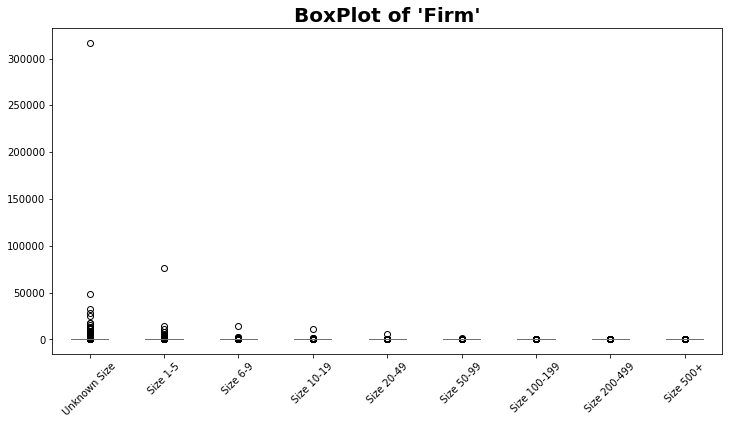

In [6]:
__ = firm_dat.plot.box(figsize=(12,6))
plt.title('BoxPlot of \'Firm\'', weight='semibold', size =20)
for i in __.xaxis.get_ticklabels():
    i.set_rotation(45)

*Aïe!*

That looks like we have a bit of an outlier - one zip code has 6x the next largest number of unknown firms. Let's examine our outliers and see if we need to remove anything.

The tricky part here is that as we increase in firm size, we expect a lot of sparsity, so we can't meaningfully examine outliers on every feature as we know that only 748 entries have >1 'Size 500+' firm!

Let's just see what we can glean from the first few features.

In [7]:
for i in firm_dat.columns[0:3]:
    # we'll log scale everything temporarily for outlier detection - with a +1 shift for sparsity
    # let's stick to only the top and bottom 10% as sparsity gaurantees a lot of massive datapoints
    
    # this took a bit of tweaking to look nice
    
    D1 = np.percentile(np.log(firm_dat[i].values + 1), 10)
    D9 = np.percentile(np.log(firm_dat[i].values + 1), 90)
    
    step = 1.8 * (D9 - D1)
    
    print "Data points considered outliers for column '{}':".format(i)
    
    display(firm_dat[~((np.log(firm_dat[i].values+1) >= D1 - step) & (np.log(firm_dat[i].values+1) <= D9 + step))])

Data points considered outliers for column 'Unknown Size':


,Unknown Size,Size 1-5,Size 6-9,Size 10-19,Size 20-49,Size 50-99,Size 100-199,Size 200-499,Size 500+
Geo Code,,,,,,,,,
75056,316603,76368,14836,10829,5643,1658,812,456,180


Data points considered outliers for column 'Size 1-5':


,Unknown Size,Size 1-5,Size 6-9,Size 10-19,Size 20-49,Size 50-99,Size 100-199,Size 200-499,Size 500+
Geo Code,,,,,,,,,
75056,316603,76368,14836,10829,5643,1658,812,456,180


Data points considered outliers for column 'Size 6-9':


,Unknown Size,Size 1-5,Size 6-9,Size 10-19,Size 20-49,Size 50-99,Size 100-199,Size 200-499,Size 500+
Geo Code,,,,,,,,,
06088,28345,8148,1298,911,414,104,62,23,9
13055,48557,14268,2432,1599,908,318,148,82,20
31555,24584,8163,1632,1237,735,254,125,65,28
33063,17800,5883,1017,725,456,127,56,39,13
34172,17495,4833,908,678,380,126,47,29,12
44109,15381,4808,963,683,461,160,77,38,14
59350,13148,4455,927,640,400,109,60,36,12
67482,13604,5025,960,660,398,138,49,36,12
69123,33047,11452,2171,1525,974,333,135,90,29


As you can see, we have many more outliers in the third feature - in fact, if we were to use the same metric on the last few features, we'd have several hundred, far more than we can afford to remove!

Clearly, we need to remove Geo Code 75056 (a zip code in Paris), but many of the other zip codes seem fairly close to each other, and probably represent the bulk of the interesting part of the data.

In [8]:
paris_outlier = firm_dat.loc['75056']
firm_dat.drop('75056', axis=0, inplace=True)

It wasn't perfectly clear in the boxplot above, but it looked like we had some highly skewn data. Let's look at another visualization, a scattermatrix, which can also tell us a bit about collinearity.

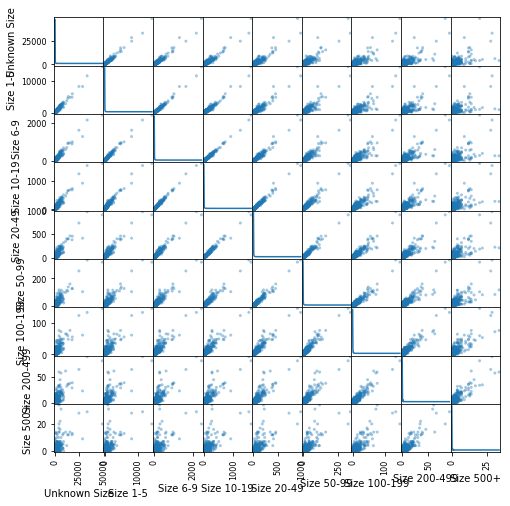

In [9]:
scatter_matrix(firm_dat, alpha=0.4, diagonal='kde', figsize=(8,8));

*Oui*

That's a lot of skew in the '**firm**' data, which suggests we may need to use a power transform to reshape data and have more useful/normally distributed features (which helps with meaningful analysis). Let's try out two different transformations and see how they compare.

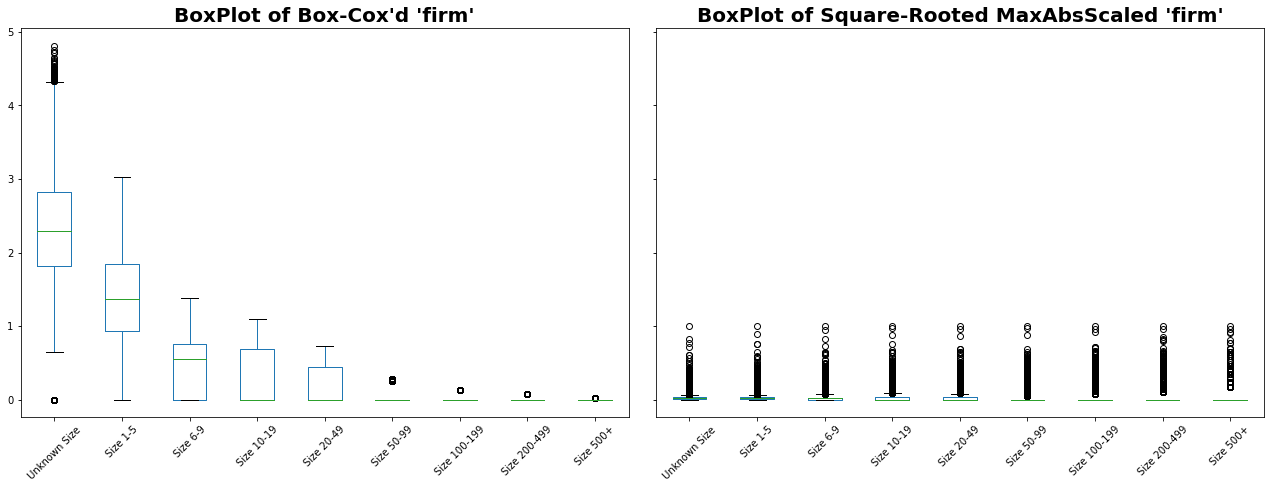

In [10]:
# first, let's try a Box-Cox transformation
# the Box-Cox transform is used in advanced data anslysis and attempts to normalize the data 
boxed_firm_dat = pd.DataFrame(firm_dat, copy=True, columns = firm_dat.keys())
lambda_list = pd.Series(index=firm_dat.keys())

# Sparsity issues necessitate a two-parameter Box-Cox transformation
# more specifically, we add an alpha term of 1 so that zero entries can still be transformed
# this does destroy sparsity, but we can re-introduce it later
boxed_firm_dat += 1
for i in boxed_firm_dat.columns:
    boxed_firm_dat[i], lambda_list.loc[i] = boxcox(boxed_firm_dat[i])

# we add a one row, two column format to see the results side-by-side
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(18,6))
plt.tight_layout()

# add the first plot, of the Box-Cox transform 
__ = boxed_firm_dat.plot.box(ax = ax)
ax.set_title('BoxPlot of Box-Cox\'d \'firm\'', weight='semibold', size =20)
for i in __.xaxis.get_ticklabels():
    i.set_rotation(45)

# Our second transformation divides the data by the maximum value, which makes all of the data between zero and one
# this technique preserves sparsity and can ensure all of the features are on the same scale
# to make this more normal, we also take a square root, which reduces the variance and skew
maxAbs = MaxAbsScaler(copy=True)
sqAbs_firm_dat = pd.DataFrame(np.sqrt(maxAbs.fit_transform(firm_dat)), columns=firm_dat.keys())

# add the second plot,of the SqAbsScaled data
__ = sqAbs_firm_dat.plot.box(ax = ax2)
ax2.set_title('BoxPlot of Square-Rooted MaxAbsScaled \'firm\'', weight='semibold', size =20)
for i in __.xaxis.get_ticklabels():
    i.set_rotation(45)

Above we used the Box-Cox transformation and a MaxAbsScaler transformation. The former is comparable to a log transformation, although it optimizes the data for normality; we also used the two-parameter Box-Cox transform to deal with our zero entries. The latter normalizes the data from zero to one, which should weight the features more evenly and help with outliers. We also added a square root transformation to the MaxAbsScaler transformation to reduce the variance. 

Let's examine each in a scattermatrix and see what popped out.

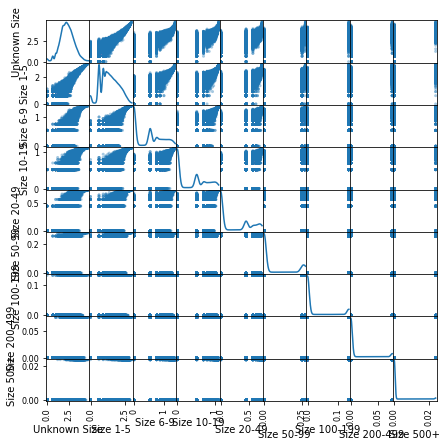

In [11]:
__ = scatter_matrix(boxed_firm_dat, alpha=0.4, diagonal='kde', figsize=(7,7))

The Box-Cox transformation doesn't look good. It creates a normal-looking distribution on the first (and possibly second) feature, but after that there's just too much sparsity to do much. We could break each feature into zero and non-zero subsets, similar to mixed random variables, but we've already altered the covariance matrix significantly by transforming each feature independently. It would also likely be overly complex to split each feature as such, so we'll leave it for a later project.

Of course, looks can be deceiving, so we'll see if the Box-Cox comes in handy later.

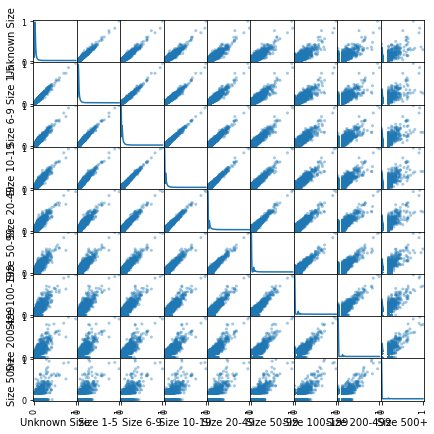

In [12]:
__ = scatter_matrix(sqAbs_firm_dat, alpha=0.4, diagonal='kde', figsize=(7,7));

The Square-rooted MaxAbsScaler also seems to not be a perfect transformation, but it likely created an interesting covariance matrix that may prove interesting later. 

At least we have managed to create a few different transformations of our data that may help us in clustering. We may also want to examine the collinearity of the data to examine the dimensionality of the data before we begin to cluster. To do this, we'll use a common indicator of collinearity, the variance inflation factor, or VIF.

We also need to add a column of ones to serve as the intercept in Python, so the last VIF for each dataframe won't be very meaningful.

In [13]:
print('VIFs for the cleaned, original data: ')
vifs_firm_dat = [vif(firm_dat.assign(ones=1).as_matrix(),i) for i in range(firm_dat.shape[1])]
print(np.round(vifs_firm_dat, 2))

print('\nVIFs for the Box-Cox data: ')
vifs_boxed_dat = [vif(boxed_firm_dat.assign(ones=1).as_matrix(),i) for i in range(boxed_firm_dat.shape[1])]
print(np.round(vifs_boxed_dat,2))

print('\nVIFs for the SqAbsScaled data: ')
vifs_sqAbs_dat = [vif(sqAbs_firm_dat.assign(ones=1).as_matrix(),i) for i in range(sqAbs_firm_dat.shape[1])]
print(np.round(vifs_sqAbs_dat,2))

VIFs for the cleaned, original data: 
[  36.48  102.18  108.73   97.26   56.69   24.26   14.39    9.49    4.18]

VIFs for the Box-Cox data: 
[ 5.03  5.19  2.75  2.63  2.4   1.94  1.69  1.53  1.23]

VIFs for the SqAbsScaled data: 
[ 20.17  31.81  12.47  10.72   8.26   5.31   3.83   2.96   1.94]


*Sacrebleu!*

That's a lot of collinearity in the original data. A variance inflation factor, or VIF, is a measure of the similarity between features in a dattaset. Basically, it tells us if any columns can be recreated by other columns and are thus redundant (or creating singular matrices). Anything above 5 is regarded as collinear, and VIFs much higher than that likely necessitate processing to ensure a the data is usable.

The untransformed data has a smallest VIF os 9.49! (the last VIF is the intercept column) This means that we likely are looking at nearly single-dimensional data and even after a collinearity reduction technique such as Principal Components Analysis, or PCA, we may still have a some issues. The Box-Cox is very promising, although we still have two columns with VIFs just over 5, so we may examine clustering with and without PCA. The SqAbsScaled data is much better than the original data, but we still notice a high number of VIFs over 5, so we should definitely use PCA.

PCA can also increase our computational efficiency and improve clusterability by reducing dimensionality, so which can also reduce the dimensionality to improve clusterability. This does come at the cost of lost information, so we may cluster our original data without PCA to verify by comparability the integrity of our PCA'd data. 

In [14]:
np.set_printoptions(precision = 4, suppress=True)

print('Original data PCA explained variance by component: ')
pca_firm = PCA(n_components=2)
pca_firm.fit(firm_dat)
print(pca_firm.explained_variance_ratio_)

print('\nBox-Cox data PCA explained variance by component: ')
pca_firm_boxed = PCA(n_components=2)
pca_firm_boxed.fit(boxed_firm_dat)
print(pca_firm_boxed.explained_variance_ratio_)

print('\nSqAbs data PCA explained variance by component: ')
pca_firm_sqAbs = PCA(n_components=2)
pca_firm_sqAbs.fit(sqAbs_firm_dat)
print(pca_firm_sqAbs.explained_variance_ratio_)

Original data PCA explained variance by component: 
[ 0.9967  0.0031]

Box-Cox data PCA explained variance by component: 
[ 0.8273  0.0668]

SqAbs data PCA explained variance by component: 
[ 0.8159  0.0618]


Principle component analysis, or PCA, is statistical technique that simplifies data (so it's easier to visualize and to compute) and also helps us solve structural issues like collinearity. What we see above is the estimate of how well we can express the data in reduced dimensions, namely 2 dimensions for each of the datasets above.

Our original dataset is certainly collinear: a single dimension explains over 99.9% of the variation in the data - basically it's all just one straight line. This means any clustering will likely be by density rather than unique business structure.

Now, let's start clustering! We'll use GaussianMixtureModel (GMM) and KMeans, two typical clustering algorithms that perform similarly but with a few differences - GMMs assume normality, so the Box-Cox data may perform much differently for the two algorithms.

**Technical Note:** PCA is not robustified to sparsity, and while recent developments in Robust PCA methods exist (such as Candes, Li, Ma, Wright (2009)), we consider them beyond the scope of this project as they require sophisticated knowledge of convex optimization and are not implemented in Sci-Kit Learn or other typical Python modules as of yet. Thus, we should not consider this PCA to be a prefect projection of our data, although it allows us to cluster and predict to a sufficient degree of accuracy to be interesting.  

In [15]:
# The next couple of steps create dicts for us to recycle code

# Here we create a list of columns and clustering algos
data_cols = ['Orig', 'PCA Orig','Box-Cox','PCA BxCx','PCA SqAbs']
cluster_algos = [GaussianMixture, KMeans]

# Here we create our PCA'd data and store all of the data in a dict for ease of use
pca_firm_dat = pca_firm.transform(firm_dat)
pca_boxed_firm_dat = pca_firm_boxed.transform(boxed_firm_dat)
pca_sqAbs_firm_dat = pca_firm_sqAbs.transform(sqAbs_firm_dat)

datasets = dict(zip(data_cols,[firm_dat,pca_firm_dat,boxed_firm_dat,pca_boxed_firm_dat,pca_sqAbs_firm_dat]))

# we have some dimensinoality issues with the PCA Orig data, so we only cluster for 3+ clusters
t = range(2,10)
cluster_range = dict(zip(data_cols,[t,range(3,10),t,t,t]))

# these hold our predictions and centers
gmm_preds = {}
gmm_centers = {}
kmeans_preds = {}
kmeans_centers = {}

# place our preds and centers into a dict 
preds = dict(zip(cluster_algos,[gmm_preds,kmeans_preds]))
centers = dict(zip(cluster_algos,[gmm_centers,kmeans_centers]))

# GaussianMixture and KMeans have different arguments and attributes, so we need dicts for that
count = dict(zip(cluster_algos,['n_components','n_clusters']))
attributes = dict(zip(cluster_algos,['means_','cluster_centers_']))

for dat in data_cols:
    for algo in cluster_algos:
        for i in cluster_range[dat]:
            # we can simply our calls by grabbing the appropriate data and predictions etc. from dicts
            # pass by reference for the win
            
            # let's slice those dicts into easier to read formats 
            data = datasets[dat]
            preds_dict = preds[algo]
            cluster_dict = centers[algo]
            cluster_count = count[algo]
            
            # here we deal with the different arguments and attributes
            arguments = {cluster_count:i,'random_state':1920}
            centroid_attribute = attributes[algo]
            
            # here we fit the clusterer with each algo from cluster_algos
            clusterer = algo(**arguments)
            clusterer.fit(data)
            
            # here we add the preds and centers to our dicts of preds and center for each algo
            preds_dict[(dat,i)] = clusterer.predict(data) 
            cluster_dict[(dat,i)] = getattr(clusterer, centroid_attribute)

Now we've created a number of clusterings to choose from. At this point, we can visualize some of the clusterings (those PCA'd to two dimensions are easiest) and consider different metrics to evaluate them. Let's start with a visualization of some of the PCA's to see if any clusters seem invalid and suggest other validation techniques as well.

Below we examine three clusterings from each of the PCA'd data for both GMM and KMeans.

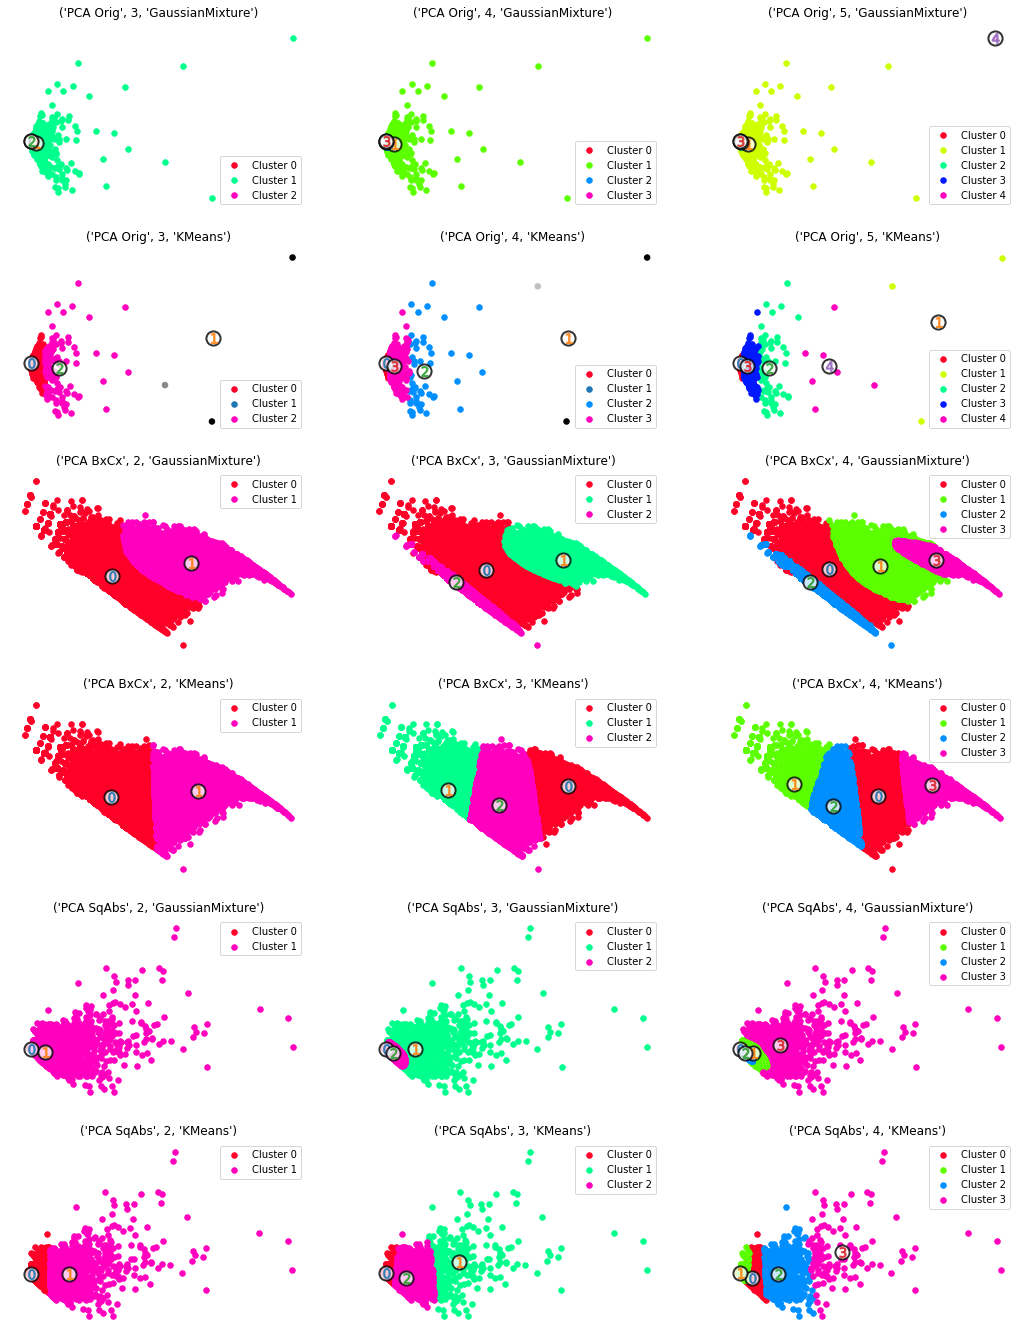

In [16]:
# create a dict of cluster counts for each of our datasets
cluster_counts = {}

cluster_list = ['PCA Orig', 'PCA BxCx', 'PCA SqAbs']

# iterate over a few clusters for the PCA'd datasets
cluster_counts[cluster_list[0]] = [3, 4, 5]
cluster_counts[cluster_list[1]] = [2, 3, 4]
cluster_counts[cluster_list[2]] = [2, 3, 4]

# create a nice figure
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15),
      (ax16, ax17, ax18)) = plt.subplots(nrows=6, ncols=3, sharey= 'row', figsize = (18,24))
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18]
ax_count = 0
cmap = cm.get_cmap('gist_rainbow')


for i in cluster_list:    
    data = pd.DataFrame(datasets[i], columns=['Dimension 1', 'Dimension 2'])
    
    for algo in cluster_algos:
        for j in cluster_counts[i]:
            # we can simply our calls by grabbing the appropriate data and predictions etc. from dicts
            # pass by reference for the win
            preds_dict = preds[algo]                   
            predictions = pd.DataFrame(preds_dict[(i,j)], columns = ['Cluster'])            
            center_list = centers[algo]
            
            # this adds an index to the data            
            plot_data = pd.concat([predictions, data.iloc[:,0:2]], axis = 1)

            # update the axes being used in the plot
            axes = ax_list[ax_count]
            axes.set_title((i,j,algo.__name__))
    
            for k, cluster in plot_data.groupby('Cluster'):                
                cluster.plot(ax = axes, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                             color = cmap((k)*1.0/(len(center_list[(i,j)])-1)), label = 'Cluster %i'%(k), s=30);

            for k, c in enumerate(center_list[(i,j)]):
                axes.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                           alpha = .8, linewidth = 2, marker = 'o', s=200);
                axes.scatter(x = c[0], y = c[1], marker='$%d$'%(k), alpha = .8, s=100);

            # remove some 'chart junk' as it's called
            axes.xaxis.set_visible(False)
            axes.yaxis.set_visible(False)
            for spine in axes.spines.values():
                spine.set_visible(False)
            
            # iterate through our axes
            ax_count += 1

*Feux d'artifice!*

At first glance, we can see that we have a variety of possible clusterings across data that's been transformed in different ways. However, especially in the PCA'd Original data under GMMs, it's unclear if some of the clusters have **any** points as the plots seem monotone.

We may have similar issues across the other datasets as well, so let's examine the ratio of largest cluster count to smallest cluster count for each of the clusterings across the datasets.

$$\textrm{ratio}=\frac{max(n_{(i.j), k})}{min(n_{(i.j), k})} $$
$$\textrm{where n is the count for each (i,j) a (Dataset, Cluster Count) and k a cluster assignment (e.g. cluster 0)} $$

Below we sort the ratios in descending order.

In [17]:
cluster_index = gmm_preds.keys()

cluster_analysis_gmm = pd.Series(index = cluster_index)
cluster_analysis_kmeans = pd.Series(index = cluster_index)
                                 
cluster_analysis = {GaussianMixture: cluster_analysis_gmm,KMeans: cluster_analysis_kmeans}

for algo in cluster_algos:
    print(algo.__name__)
    preds_dict = preds[algo]
    analysis_series = cluster_analysis[algo]
    
    for j in cluster_index:
        
        predictions = preds_dict[j]

        total = len(predictions)

        values = np.unique(predictions)
        
        # pick gauranteed-to-change maxes and mins 
        maxi = 0
        mini = 36000

        for k in values:
            value_count = sum(predictions == k)
            if(value_count > maxi):
                maxi = value_count
            if(value_count < mini):
                mini = value_count
        
        ratio = maxi/mini
        
        analysis_series.loc[j] = ratio
    
    analysis_series = analysis_series.sort_values(ascending = False)
    display(analysis_series[analysis_series>50])


GaussianMixture


(Orig, 5)         23608.0
(Orig, 6)         23550.0
(Orig, 7)         23546.0
(Orig, 8)         23520.0
(Orig, 9)         23517.0
(PCA Orig, 5)     16013.0
(PCA Orig, 6)     13821.0
(PCA Orig, 7)     13239.0
(PCA Orig, 9)     12983.0
(PCA Orig, 8)     12982.0
(PCA SqAbs, 8)     6561.0
(PCA SqAbs, 9)     6397.0
(Orig, 3)          4228.0
(Orig, 4)          3933.0
(PCA SqAbs, 7)      820.0
(PCA SqAbs, 6)      280.0
(PCA SqAbs, 5)       72.0
dtype: float64

KMeans


(Orig, 6)         29454.0
(PCA Orig, 6)     29454.0
(PCA Orig, 7)     28929.0
(Orig, 7)         28900.0
(Orig, 8)         27671.0
(PCA Orig, 8)     27662.0
(PCA Orig, 9)     27566.0
(Orig, 9)         27564.0
(PCA Orig, 5)      9820.0
(Orig, 5)          9820.0
(PCA Orig, 3)      7484.0
(Orig, 3)          7484.0
(PCA Orig, 4)      7387.0
(Orig, 4)          7387.0
(Orig, 2)          3004.0
(PCA SqAbs, 9)     2205.0
(PCA SqAbs, 7)     1073.0
(PCA SqAbs, 8)     1059.0
(PCA SqAbs, 6)      539.0
(PCA SqAbs, 5)      424.0
(PCA SqAbs, 4)      200.0
(PCA SqAbs, 3)       86.0
dtype: float64

It doesn't seem fitting to use a clustering that assigns > 29000 values to one cluster and only 1 to another (the only feasibility for the (Orig, 6) ratio for KMeans). The untransformed data is likely picking up a large outlier, but even with fewer clusters, it still assigns only a handful of geo codes to some clusters. 

That being said, we were right, a few of the clusterings are easily invalidated by a simple ratio check. A cluster with only one geo code isn't something we want! It looks like both clustering algorithms created many clusterings with just a handful of geo codes, something that doesn't suit us well as these likely aren't too meaningful. One thing to note is that the Box-Cox data doesn't show up in either of the lists, so it probably transformed the data in such a way as to space it out - the plots above certainly look like it.

Let's create lists of clusterings we can still use.

In [18]:
cleaned_gmm_list =  cluster_analysis_gmm[cluster_analysis_gmm <=50].index.values
cleaned_kmeans_list =  cluster_analysis_kmeans[cluster_analysis_kmeans <=50].index.values

print('Number of clean clusterings left: ')
print(len(cleaned_gmm_list) + len(cleaned_kmeans_list))

Number of clean clusterings left: 
39


We've examined a few of the clusterings visually, and that led us to realize we may have some bad clusterings that had too small clusters. There are plenty of other hand-coded criteria we could use to identify a few superior clusterings, but it may take an awfully long time to skinny our way down from 39 clusters to a handful by manual inspection.

We could certainly turn to silhouette score, or Tibshirani's and Walther's (2005) 'prediction strength', but before that, why don't we see if these clusters are learnable? Ideally, these clusters should have something in common and hopefully be almost as sensical (predictable) as INSEE's four-tier system.

## Part 2 - Learnability of the Clusterings ## 

Let's take a look at our population data, '**pop**' and see if we can clean it up.

In [19]:
pop_raw.shape
pop_raw.head(5)

,Code géographique,Région,Département,Libellé géographique,Population en 2014 (princ),Pop 0-14 ans en 2014 (princ),Pop 15-29 ans en 2014 (princ),Pop 30-44 ans en 2014 (princ),Pop 45-59 ans en 2014 (princ),Pop 60-74 ans en 2014 (princ),...,Pop 25-54 ans Autres en 2014 (compl),Pop 55 ans ou plus en 2014 (compl),Pop 55 ans ou plus Agriculteurs exploitants en 2014 (compl),"Pop 55 ans ou plus Artisans, Comm., Chefs entr. en 2014 (compl)","Pop 55 ans ou plus Cadres, Prof. intel. sup. en 2014 (compl)",Pop 55 ans ou plus Prof. intermédiaires en 2014 (compl),Pop 55 ans ou plus Employés en 2014 (compl),Pop 55 ans ou plus Ouvriers en 2014 (compl),Pop 55 ans ou plus Retraités en 2014 (compl),Pop 55 ans ou plus Autres en 2014 (compl)
1,01001,84,01,L'Abergement-Clémenciat,767,161,102,132,189,125,...,0,240,10,0,25,40,5,10,140,10
2,01002,84,01,L'Abergement-de-Varey,239,54.0947,27.5391,68.8477,36.3909,33.4403,...,0,78.6831,0,0,0,4.9177,9.83539,0,63.93,0
3,01004,84,01,Ambérieu-en-Bugey,14022,2778.16,2958.44,2641.52,2603.3,1852.89,...,579.458,3869.46,0,74.2814,91.9073,203.563,215.124,194.271,2851.77,238.536
4,01005,84,01,Ambérieux-en-Dombes,1627,335.65,251.235,322.586,375.848,232.141,...,30.1482,447.199,0,5.02471,25.1235,20.0988,25.1235,30.1482,311.532,30.1482
5,01006,84,01,Ambléon,109,11.8909,15.8545,14.8636,28.7364,26.7545,...,0,29.7273,0,0,4.95455,0,0,0,24.7727,0


That's certainly a lot of columns! Let's chop off most of them, and look only at the population for each age range (similar to the '**firm**' data above). 

If you're asking - why are we cleaning a second dataset?, don't fret. It would be easy to build a supervised learning model that learns what features best predict INSEE's human-created clusters, so why can't we do the same with our algorithm-created clusters? This may also prove insightful with regards to metrics for comparing human- and machine-created clusterings.

After we slice off the qualitative and extraneous data from '**pop**', we'll then have counts of each age range for each geo code, which should serve nicely if we wanted to learn a classification rule for geo codes on an urban-rural scale. It also has different noise than our '**firm**' data above, so any attempt to learn those clusters won't be inhibited by unusual observations in the '**firm**' data that warps the algorithms.    

A good question now is, do we have data on all of the same geo codes?

In [20]:
pop_dat = pop_raw.drop(pop_raw.columns[1:5],axis=1).set_index(pop_raw.columns[0])
pop_dat.shape

(35868, 103)

It looks like we don't have quite as many geo codes in this survey, and also we had to drop ~ 6000 null entries from **firm** -  we'll need to create a common index of geo codes to use for our learning algorithm.

In [21]:
# inner join  to get the indices of common values
common_index = (firm_dat[firm_dat.columns[0]].align(pop_dat[pop_dat.columns[0]], join= 'inner')[0]).index
display(common_index.shape)

common_pop = pop_dat.loc[common_index]

(29434,)

We see that we share ~ 29000 entries with our '**firm**' data. This is more than enough to do some nifty learning algorithms on. Now let's see if we can preprocess our population data to a more usable state.

What kind of transformations will we need?

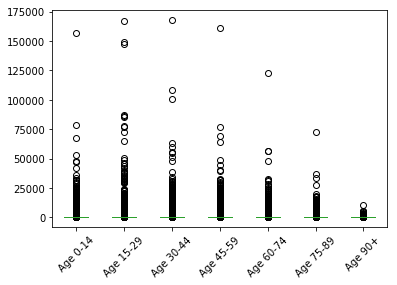

In [22]:
# let's make sure we're dealing with numeric data.
for i in common_pop.columns:
    common_pop[i] = pd.to_numeric(common_pop[i])

common_pop.drop(common_pop.columns[7:], axis = 1, inplace=True)
pop_cols = ['Age 0-14','Age 15-29','Age 30-44','Age 45-59', 'Age 60-74', 'Age 75-89', 'Age 90+']
common_pop.columns = pop_cols

__ = common_pop.plot.box()
for i in __.xaxis.get_ticklabels():
    i.set_rotation(45)

It looks like we may have an outlier or two, and we'll certainly need to use a power transform as our interquartile range is quite supressed.

Let's look for outliers and look for sparsity.

In [23]:
# sparsity check
print('Sparsity by column:')
display((common_pop==0).sum(axis=0))

# outlier check

for i in common_pop.columns:
    # we'll log scale everything temporarily for outlier detection - with a +1 shift for sparsity
    # let's stick to only the top and bottom 10% as sparsity gaurantees a lot of massive datapoints
    
    D1 = np.percentile(np.log(common_pop[i].values + 1), 10)
    D9 = np.percentile(np.log(common_pop[i].values + 1), 90)

    step = 1.5 * (D9 - D1)
    
    print "Data points considered outliers for column '{}':".format(i)
    
    display(common_pop[~((np.log(common_pop[i].values+1) >= D1 - step) & (np.log(common_pop[i].values+1) <= D9 + step))])

Sparsity by column:


Age 0-14       17
Age 15-29      12
Age 30-44       4
Age 45-59       0
Age 60-74       2
Age 75-89      20
Age 90+      3475
dtype: int64

Data points considered outliers for column 'Age 0-14':


,Age 0-14,Age 15-29,Age 30-44,Age 45-59,Age 60-74,Age 75-89,Age 90+
13055,156633.835603,167000.745329,168063.645694,160900.790119,122824.148048,72241.549627,10455.28558


Data points considered outliers for column 'Age 15-29':


,Age 0-14,Age 15-29,Age 30-44,Age 45-59,Age 60-74,Age 75-89,Age 90+
13055,156633.835603,167000.745329,168063.645694,160900.790119,122824.148048,72241.549627,10455.285580
31555,67673.817288,149265.318940,100513.867527,69428.937012,47515.640208,27436.050302,4463.368722
34172,42371.286919,87064.850628,55173.824994,40134.938620,30830.854886,17171.975078,2570.268875
69123,78801.111621,147223.235137,108655.927682,76943.033014,55997.395902,33570.742255,5423.554388


Data points considered outliers for column 'Age 30-44':


,Age 0-14,Age 15-29,Age 30-44,Age 45-59,Age 60-74,Age 75-89,Age 90+
13055,156633.835603,167000.745329,168063.645694,160900.790119,122824.148048,72241.549627,10455.285580
31555,67673.817288,149265.318940,100513.867527,69428.937012,47515.640208,27436.050302,4463.368722
69123,78801.111621,147223.235137,108655.927682,76943.033014,55997.395902,33570.742255,5423.554388


Data points considered outliers for column 'Age 45-59':


,Age 0-14,Age 15-29,Age 30-44,Age 45-59,Age 60-74,Age 75-89,Age 90+
13055,156633.835603,167000.745329,168063.645694,160900.790119,122824.148048,72241.549627,10455.28558


Data points considered outliers for column 'Age 60-74':


,Age 0-14,Age 15-29,Age 30-44,Age 45-59,Age 60-74,Age 75-89,Age 90+
13055,156633.835603,167000.745329,168063.645694,160900.790119,122824.148048,72241.549627,10455.28558


Data points considered outliers for column 'Age 75-89':


,Age 0-14,Age 15-29,Age 30-44,Age 45-59,Age 60-74,Age 75-89,Age 90+
13055,156633.835603,167000.745329,168063.645694,160900.790119,122824.148048,72241.549627,10455.28558


Data points considered outliers for column 'Age 90+':


,Age 0-14,Age 15-29,Age 30-44,Age 45-59,Age 60-74,Age 75-89,Age 90+


*Ah, Marseille*

Again, we have a relatively high variance and a very large sample size, so we can't say that too many items are outliers (hence the 10% and 90% instead of a traditional outlier approach). What's clear, however, is that Geo Code 13055 (in Marseille) has nearly double the closest population for 'Age 0-14' and 1.5x - 2x more than the others in many other categories, so we'll go ahead and cut that one out going forward. Otherwise, The other detected points seem fairly close to each other, so we'll leave them.

We also have quite a few zero entries in the '90+' column, so our power transform will need to mind that. Let's try Box-Cox and remove Marseille.

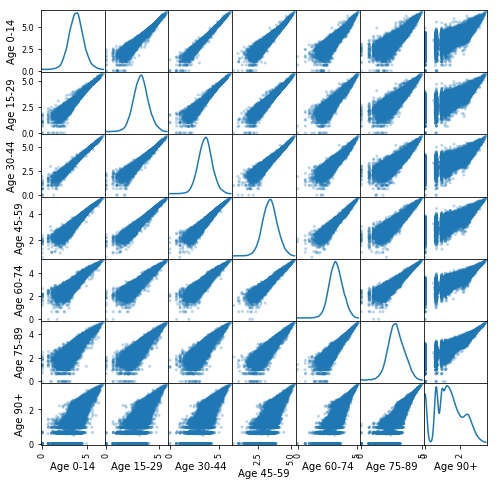

In [24]:
common_index = common_index.drop('13055')
common_pop.drop('13055', inplace = True)

boxed_pop = pd.DataFrame(common_pop, copy = True, columns=common_pop.keys())
boxed_pop += 1
lambda_pop = pd.Series(index = common_pop.keys())

for i in boxed_pop.columns:
    boxed_pop[i], lambda_pop.loc[i] = boxcox(boxed_pop[i])
    
__ = scatter_matrix(boxed_pop, alpha = 0.3, diagonal='kde', figsize=(8,8))

*Que c’est beau!*

The population data is much more suitable for a Box-Cox transformation as most of the features are quite easily normalized (aside from the sparsity present in the 'Age 90+' feature). This tells us that any clustering techniques such as GMMs would be well suited to this data, and much easier to accomplish than our firm data above (although *ce n'est pas amusant* as one could say). It also suggests we should have an easy time trying to predict with our data.

To simplify our analysis, we'll go ahead and add a layer of PCA since this saves us a bit of time later.

In [25]:
print('VIFs for the Box-Cox population data: ')
vifs_pop_dat = [vif(common_pop.assign(ones=1).as_matrix(),i) for i in range(common_pop.shape[1])]
print(np.round(vifs_pop_dat, 2))

print('Original data PCA explained variance by component: ')
pca_boxed_pop = PCA(n_components = 2)
pca_boxed_pop.fit(boxed_pop)
pca_boxed_pop.explained_variance_ratio_

VIFs for the Box-Cox population data: 
[  60.74   25.33  109.63  186.13  190.55  139.66   45.59]
Original data PCA explained variance by component: 


array([ 0.9011,  0.0661])

Here we again see a mostly one dimensional dataset, although adding a second dimension can decrease our unexplained variance by 60%, so we may as well add it (two dimensions are also great for visualization). We also see that we reduce a good deal of collinearity by PCAing as well, which may assist learnability. 

Now, back to those clusters. We want to see if they follow a sensical prediction rule, but we'll need a benchmark. Let's convert the INSEE four-tier classification system into something easy to feed to a supervised algorithm.

In [26]:
tiers_raw.set_index('CODGEO', inplace=True)
tiers_raw.head(5)

,LIBGEO,AU2010,LIBAU2010,CATAEU2010,DEP,REG
CODGEO,,,,,,
01001,L'Abergement-Clémenciat,997,Multipolarisé des grands pôles,120,01,84
01002,L'Abergement-de-Varey,002,Lyon,112,01,84
01004,Ambérieu-en-Bugey,002,Lyon,112,01,84
01005,Ambérieux-en-Dombes,002,Lyon,112,01,84
01006,Ambléon,998,Autre multipolarisé,300,01,84


The 'CATAEU2010' (Categorie EU 2010) column lists the four tiers - 100s correspond to the largest cities while 400s correspond to the smallest. The tens and ones digit refer to a subtiering we currently aren't focused on.

Now we create the benchmark 'prediction' for each geo code after once again assuring we adjust for our new common index.

In [27]:
common_index = (tiers_raw[tiers_raw.columns[0]].align(common_pop[common_pop.columns[0]], join= 'inner')[0]).index
display(common_index.shape)

common_pop = common_pop.loc[common_index]

def tier_finder(cat):
    if(cat < 200):
        return 0
    elif(cat < 300):
        return 1
    elif(cat < 400):
        return 2
    else:
        return 3
       

bench_pred = pd.to_numeric(tiers_raw['CATAEU2010'].loc[common_index]).apply(tier_finder)
bench_pred = bench_pred
bench_pred.head(5)

(29061,)

01001    0
01002    0
01004    0
01005    0
01007    0
Name: CATAEU2010, dtype: int64

We did lose a few more geo codes due to a lack of category information, but we should still be able to classify our points fairly well. Note that if we had small clusters (of say 5 geo codes), they would be much more adversely impacted by the small miscoverages by each dataset, but we should have good results due to our pre-filtering already.

Now, let's evaluate the learnability of the benchmark with a simple logistic regression classifier, on both the unpreprocessed population data and the PCA'd data (to see how PCA changes the learnability).

Yes, we did say 'learnability.' It's yet unclear in this case if silhouette score or other clustering metrics are applicable at all to our human-clustered data, but it's entirely sensical to examine the prediction accuracy of human-created classes, which we reinterpret as 'clusters.'

In [28]:
start = time.time()

X_train, X_test, y_train, y_test = TTS(pop_dat.loc[common_index], bench_pred, test_size = 0.1, random_state=1920)
lr = LogReg(random_state = 1920)
lr.fit(X_train, y_train)

bench_learn_score = lr.score(X_test, y_test)

end = time.time()

regular_learn_time = end-start

start = time.time()

X = pd.DataFrame(pca_boxed_pop.transform(boxed_pop), index=boxed_pop.index)
X_train, X_test, y_train, y_test = TTS(X.loc[common_index], bench_pred, test_size = 0.1, random_state=1920)
lr.fit(X_train, y_train)

bench_pca_learn_score = lr.score(X_test, y_test)

end = time.time()

pca_learn_time = end-start

print('\nBenchmark learning score:')
print(bench_learn_score)

print('\nTime to compute on benchmark: ')
print(regular_learn_time)

print('\nBenchmark learning score after PCA:')
print(bench_pca_learn_score)

print('\nTime to compute on PCA\'d data:')
print(pca_learn_time)


Benchmark learning score:
0.642930856553

Time to compute on benchmark: 
79.0352928638

Benchmark learning score after PCA:
0.624699002408

Time to compute on PCA'd data:
0.293826818466


So we see that a logistic regression only achieves a (benchmark) 64.3% testing accuracy on nothing but population data. This suggests that the proximity to other large, urban areas significantly impact the classification of the geo codes in France. Chances are, if we introduced latitude and longitude data as a proxy to the proximity data. 

Of course, having four different classes also decreases the accuracy as does using a simple logistic regression model without higher order features or interactions. We're not exactly trying to build a Reproducing Kernel Hilbert Space model or ResNet...  

Let's try establishing a second benchmark with a decision tree just to be sure 64.3% is a good baseline.

In [29]:
classer = DTC(max_depth = 5)

# we use the PCA'd pop data here as well
classer.fit(X_train, y_train)

second_bench_learn_score = classer.score(X_test, y_test)
print(second_bench_learn_score)

0.627106983144


Here we see a decision tree achieves about the same level of accuracy as our logistic regression. It seems that while we may expect a high prediction accuracy for the human-classified geo codes, it doesn't track perfectly well with population size. We could certainly add in additional features to see what else spurs the learnability of INSEE's four-tier system or create higher order and interaction features in future projects.

Lets see if the clusters we created by our clustering algorithms achieve a better 'learnability.'

In [30]:
valid_clusterings = {GaussianMixture: cleaned_gmm_list, KMeans: cleaned_kmeans_list}

gmm_learn_scores = pd.Series(index = cleaned_gmm_list)
kmeans_learn_scores = pd.Series(index = cleaned_kmeans_list)

clustering_scores = {GaussianMixture: gmm_learn_scores, KMeans: kmeans_learn_scores}

start = time.time()

for algo in cluster_algos:
    clustering_list = valid_clusterings[algo]
    preds_dict = preds[algo]
    score_list = clustering_scores[algo]
    
    for i in clustering_list:
        predictions = pd.Series(preds_dict[i], index=firm_dat.index).loc[common_index]
        y_train, y_test = TTS(predictions, test_size = 0.1, random_state = 1920)
        
        lr.fit(X_train, y_train)
        
        score_list[i] = lr.score(X_test, y_test)

end = time.time()

total_learn_time = end - start
        
gmm_out = gmm_learn_scores.sort_values(ascending = False)
kmeans_out = kmeans_learn_scores.sort_values(ascending = False)

print(str(GaussianMixture.__name__) + ' \t \t \t' + str(KMeans.__name__))
for i in range(0,13):
    out = str(gmm_out.index.values[i]) + '     \t' +  str(np.round(gmm_out.iloc[i],3))+ '     \t' + str(kmeans_out.index.values[i]) + '     \t' + str(np.round(kmeans_out.iloc[i],3))
    print(out)

GaussianMixture 	 	 	KMeans
('Orig', 2)     	0.941     	('PCA SqAbs', 2)     	0.973
('PCA Orig', 3)     	0.881     	('PCA BxCx', 2)     	0.914
('PCA SqAbs', 2)     	0.865     	('Box-Cox', 2)     	0.913
('Box-Cox', 2)     	0.862     	('PCA BxCx', 3)     	0.819
('PCA BxCx', 2)     	0.852     	('Box-Cox', 3)     	0.817
('PCA SqAbs', 3)     	0.84     	('PCA BxCx', 4)     	0.697
('Box-Cox', 3)     	0.821     	('Box-Cox', 4)     	0.696
('PCA Orig', 4)     	0.788     	('PCA BxCx', 5)     	0.638
('PCA SqAbs', 4)     	0.78     	('Box-Cox', 5)     	0.633
('Box-Cox', 4)     	0.692     	('PCA BxCx', 6)     	0.547
('PCA BxCx', 3)     	0.666     	('Box-Cox', 6)     	0.532
('Box-Cox', 5)     	0.607     	('Box-Cox', 7)     	0.503
('PCA BxCx', 4)     	0.59     	('PCA BxCx', 7)     	0.491


It looks like we have some learnable clusters! 

In order to compare apples to apples, however, it would be best to examine clusterings that present the same number of clusters as INSEE - having two clusters wouldn't likely be too useful for establishing an urban-rural scale nor be able to tell us about the validity of our metrics. Fortunately, it looks like we have several clusterings of cardinality four that achieve higher 'learnabilities.' 

Below we define 'prediction strength,' a metric for cluster validation developed by Tibshirani and Walther (2005). This gives us a score from zero to one about how reproducable a clustering is for a 50/50 split of the data to be clustered. Note that this requires matching the cluster numbers in a training and testing clustering, so we create a cluster_matcher function that does this for us.

$ \textrm{Step 1: Split the data into 50/50 train-test-split} $  
$ \textrm{Step 2: Find 'n' centroids for the training data with the selected algorithm} $
$ \textrm{Step 3: Cluster the testing data with 'n' centers via the selected algorithm to find 'true labels'} $
$ \textrm{Step 4: Assign the testing data to clusters from the training centroids to find 'predictions'} $
$ \textrm{Step 5: Define 'prediction strength' as the accuracy for the cluster with the lowest accuracy, e.g.}$

$$\textrm{'prediction strength'} = \min_{1 \leq k \leq n}\frac{\left|C_{k,k}\right|}{\left|\cup_{i=1}^nC_{k,i}\right|} $$

$$\textrm{Where } \left|C_{k,k}\right| \textrm{ is the number of elements in test cluster k predicted to be in cluster k }$$
$$\textrm{And } \left|\cup_{i=1}^nC_{k,i}\right| \textrm{ is the number of elements in test cluster k assigned to any cluster (= total number of elements in cluster k) }$$


**Technical note** 'Prediction strength' is define for unsupervised clusters, so it's not traditionally used to score data with classes, such as our benchmark. We do however, propose a solution to give us another (in this case, hand-wavey) metric to compare our clusterings to the benchmark. The score still functions as intended (barring implementation errors) for unsupervised clusters, such as the ones we created with GMM and Kmeans. The tweak for supervised data is simply to train a supervised (in this case, logistic regression again) learning algorithm on 50% of the data and score it on the remaining 50%, recording the misclassifications as 'wrongly clustered' data (similar to above). This is identical to Steps 1-5 above, but with the selected algorithm being logistic regression, the centroids/clusters being classes, and the 'true labels' the actual, labeled training data. 

Direct link to Tibshirani's and Walther's 2005 paper on prediction strength -   
http://statweb.stanford.edu/~gwalther/predictionstrength.pdf

R Documentation for prediction strength (for additional explanation/comparison) -   
https://www.rdocumentation.org/packages/fpc/versions/2.1-10/topics/prediction.strength


In [31]:
gmm_accepts = [('PCA Orig',4),('PCA SqAbs',4)]
kmeans_accepts = [('PCA BxCx',4)] 

# this helper function makes sure that the clusters match - otherwise we may have accurate 
# clusterings that are just in the wrong order
def cluster_matcher(train_centers, test_centers):
    cluster_matching_dict = {}
    cluster_distance_dict = {}
    
    for train_cluster_num,train_cluster_coords in enumerate(train_centers):
        for test_cluster_num,test_cluster_coords in enumerate(test_centers):
            cluster_distance_dict[(train_cluster_num, test_cluster_num)] = np.linalg.norm(train_cluster_coords - test_cluster_coords)
    
    # this combinatoric solution helps us find the minimum distance 
    combo_list = [zip(x, range(len(test_centers))) for x in itertools.permutations(range(len(train_centers)), len(test_centers))]        
    
    # large distance to be overwritten
    min_dist = 10000000000
    
    for combo in combo_list:
        total_dist = 0
        for mapping_point in combo:
            total_dist += cluster_distance_dict[mapping_point]
        if total_dist < min_dist:
            min_dist = total_dist
            cluster_matching_dict = dict(combo)
            
    #display(min_dist)
            
    return cluster_matching_dict

# here we define 'prediction strength' with a small tweak for our benchmark
def pred_strength(covariates, algo, k, labelled = False, true_labels=None):

    # create the 50/50 split training and testing cluster data
    X_train, X_test = TTS(covariates, test_size = 0.5, random_state = 1921)
    
    if(labelled == False):
        # here we deal with the different arguments and attributes
        cluster_count = count[algo]
        arguments = {cluster_count:k,'random_state':1921}
        centroid_attribute = attributes[algo]

        # establish find a clustering algo fit for the appropriate size
        clusterer = algo(**arguments)

        # let's collect the labelled test data
        clusterer.fit(X_test)    
        test_centers = getattr(clusterer, centroid_attribute)
        test_labels = clusterer.predict(X_test)

        # now we 'train' our clusterer and predict the test labels
        clusterer.fit(X_train)
        train_centers = getattr(clusterer, centroid_attribute)
        test_predictions = clusterer.predict(X_test)

        # let's create our map to match the clusters in each set
        cluster_mapping = cluster_matcher(train_centers, test_centers)
        cluster_mapper = np.vectorize(cluster_mapping.get)

        # apply the map to our test_predictions 
        test_predictions = cluster_mapper(test_predictions)

        # compare all of the tests to the labels
        difference_array = test_labels == test_predictions 

        # find the cluster with the lowest accuracy - this is the 'prediction strength' 
        min_acc = 1.0    
        for cluster_num in np.unique(test_labels):
            acc = float(sum(difference_array[test_labels == cluster_num]))/sum(test_labels == cluster_num)
            if acc < min_acc:
                min_acc = acc

        return min_acc
    else:
        ''' 
        Note that this metric is designed for entirely unlabelled data, but we propose a tweak
        that can help establish the 'prediction strength' of a pre-labelled dataset.

        Instead of using an unsupervised learning algorithm, we use logistic regression and treat
        the predicted classes as though they were clusters.

        This allows us to establish a 'prediction strength' on our benchmark using our data.
        '''
    
        y_train, y_test = TTS(true_labels, test_size = 0.5, random_state = 1921)
        
        lr = LogReg(random_state=1921) 
        
        # create the test labels and train labels
        # the test labels should be nearly identical to the original labels 
        lr.fit(X_test, y_test)
        test_labels = lr.predict(X_test)
        lr.fit(X_train, y_train)
        train_labels = lr.predict(X_test)
        
        # compare all of the tests to the labels
        difference_array = (test_labels == train_labels)

        # find the cluster with the lowest accuracy - this is the 'prediction strength' 
        min_acc = 1.0    
        
        for cluster_num in np.unique(test_labels):
            acc = float(sum(difference_array[test_labels == cluster_num]))/sum(test_labels == cluster_num)
            if acc < min_acc:
                min_acc = acc
                
        return min_acc

Now that we've created a 'prediction strength' function, let's start analyzing the clusters we were interested in and compare them to our benchmark.

Note that since these metrics are unsupervised - we have to match our benchmark to the proper dataset to have a valid silhouette/prediction strength score. Additionally, since our sampl sizes are large, it's quite probable that we'll need to compute silhouette score on a smaller batch and have a decent level of precision for our 'prediction strength' as the clusters will likely converge.

In [32]:
for clustering in zip(gmm_accepts,[GaussianMixture,GaussianMixture]) + zip(kmeans_accepts, [KMeans]):
    
    algo = clustering[1]
    dat = clustering[0][0]
    k = clustering[0][1]
    
    preds_dict = preds[algo]
    predictions = preds_dict[(dat,k)]
    
    print(((dat,k),algo.__name__))
    
    data = pd.DataFrame(datasets[dat], index = firm_dat.index)    
    
    bench_pred_sil_score = silhouette_score(data.loc[common_index], bench_pred, sample_size= 10000, random_state=1920)
    bench_pred_strength = pred_strength(data.loc[common_index], algo, k, labelled=True, true_labels = bench_pred)
    sil_score = silhouette_score(data, predictions, sample_size = 10000, random_state = 1920)
    pred_strength_score = pred_strength(data, algo, k)
    
    print('Benchmark Silhouette: ' + str(np.round(bench_pred_sil_score,5)))
    print('Benchmark Pred Strength: ' + str(np.round(bench_pred_strength,5)))
    print('Actual Silhouette: ' +  str(np.round(sil_score,5)))
    print('Actual Pred Strength: ' +  str(np.round(pred_strength_score,5)))
    
    print('-------')
    

(('PCA Orig', 4), 'GaussianMixture')
Benchmark Silhouette: -0.44129
Benchmark Pred Strength: 1.0
Actual Silhouette: 0.4652
Actual Pred Strength: 0.96861
-------
(('PCA SqAbs', 4), 'GaussianMixture')
Benchmark Silhouette: -0.32061
Benchmark Pred Strength: 1.0
Actual Silhouette: 0.55979
Actual Pred Strength: 0.96972
-------
(('PCA BxCx', 4), 'KMeans')
Benchmark Silhouette: -0.10936
Benchmark Pred Strength: 0.8676
Actual Silhouette: 0.43373
Actual Pred Strength: 0.98544
-------


Above we see that the clusterings we chose have a demonstrably higher silhouette score than the benchmark clustering provided by INSEE, and that our prediction strengths are all above 0.95 (> 0.9 is typically a very good clustering, although to be fair we should examine the same algorithms on different cluster counts).

That's not to say that the clustering INSEE chose is bad - it's sensical and easy for us humans to compute. However, it's clear that silhouette score isn't a very good metric for pre-labelled data. Perhaps our supervised learning metric is a better choice - let's examine it!

Below, we compare the three metrics discussed in terms of the Spearman correlation coefficient to better understand how the three metrics compare on some of our datasets.

In [33]:
from scipy.stats import spearmanr

gmm_sils_scores = pd.Series(index = cleaned_gmm_list)
gmm_preds_scores = pd.Series(index = cleaned_gmm_list)
kmeans_sils_scores = pd.Series(index = cleaned_kmeans_list)
kmeans_preds_scores = pd.Series(index = cleaned_kmeans_list)

clustering_sils_scores = {GaussianMixture: gmm_sils_scores, KMeans: kmeans_sils_scores}
clustering_preds_scores = {GaussianMixture: gmm_preds_scores, KMeans: kmeans_preds_scores}

# silhouette score
start = time.time()

for algo in cluster_algos:
    clustering_list = valid_clusterings[algo]
    preds_dict = preds[algo]
    score_list = clustering_sils_scores[algo]
    
    for i in clustering_list:
        dat = i[0]
        data = datasets[dat]
        
        predictions = pd.Series(preds_dict[i], index=firm_dat.index)      
        score_list[i] = silhouette_score(data, predictions, sample_size =5000, random_state=1920)

end = time.time()

total_sils_time = end - start

## pred strength
start = time.time()

for algo in cluster_algos:
    clustering_list = valid_clusterings[algo]
    preds_dict = preds[algo]
    score_list = clustering_preds_scores[algo]
    
    for i in clustering_list:
        dat = i[0]
        data = datasets[dat]
        
        predictions = pd.Series(preds_dict[i], index=firm_dat.index)      
        score_list[i] = pred_strength(data, algo = algo, k = i[1])

end = time.time()

total_pred_time = end - start

print('Total silhouette time: ' + str(np.round(total_sils_time,4)))
print('Total pred strength time: ' + str(np.round(total_pred_time,4)))
print('Total learn time (above): ' + str(np.round(total_learn_time,4)))

print('------')

print('Silhouette and Learnability Spearman: ')
print('GMM: '+ str(np.round(spearmanr(gmm_sils_scores, gmm_learn_scores)[0],4)) + '    \tKMeans: ' + str(np.round(spearmanr(kmeans_sils_scores,kmeans_learn_scores)[0],4)))
print('')
print('Silhouette and Prediction Strength Spearman: ')
print('GMM: '+ str(np.round(spearmanr(gmm_sils_scores, gmm_preds_scores)[0],4)) + '    \tKMeans: ' + str(np.round(spearmanr(kmeans_sils_scores,kmeans_preds_scores)[0],4)))
print('')
print('Prediction Strength and Learnability Spearman: ')
print('GMM: '+ str(np.round(spearmanr(gmm_preds_scores, gmm_learn_scores)[0],4)) + '    \tKMeans: ' + str(np.round(spearmanr(kmeans_preds_scores,kmeans_learn_scores)[0],4)))

Total silhouette time: 41.9539
Total pred strength time: 45.0106
Total learn time (above): 11.7115
------
Silhouette and Learnability Spearman: 
GMM: 0.8069    	KMeans: 0.6127

Silhouette and Prediction Strength Spearman: 
GMM: 0.6836    	KMeans: 0.3922

Prediction Strength and Learnability Spearman: 
GMM: 0.5768    	KMeans: 0.7181


We discuss the results of the Spearman tests below in the conclusion. Before then, let's actually take a look and see what our clusters are! Below we use parallel coordinates to highlight the differences in feature spaces for each of our clusterings and the benchmark on the orignal data. 

Cluster counts for Benchmark: 
0: 16542    	1: 2282    	2: 5194    	3: 5043    	
Cluster Counts for PCA Orig, 4, GaussianMixture: 
3: 9065    	0: 16079    	1: 944    	2: 3962    	
Cluster Counts for PCA SqAbs, 4, GaussianMixture: 
0: 19797    	3: 1100    	2: 5526    	1: 3627    	
Cluster Counts for PCA BxCx, 4, KMeans: 
2: 10426    	1: 7479    	3: 5168    	0: 6977    	


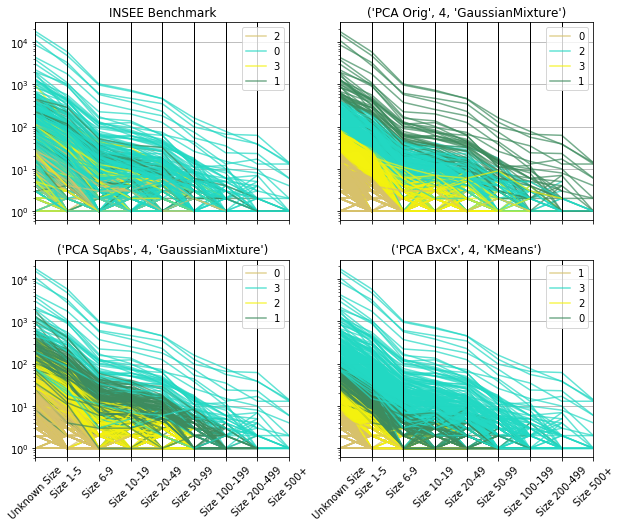

In [34]:
# create a figure with subplots
fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2, sharey = 'all', sharex='all', figsize=(10,8))
ax_list = [ax1, ax2, ax3, ax4]
ax_count = 1

ax1.set_title('INSEE Benchmark')
temp_firm = firm_dat.copy().loc[common_index]
temp_firm['Preds'] = bench_pred
pd.plotting.parallel_coordinates(temp_firm.sample(n=1200,random_state = 1920), 'Preds', ax=ax1, alpha = 0.7);

print('Cluster counts for Benchmark: ')
pred_unique = temp_firm['Preds'].unique()
out = ''
for j in pred_unique:
    pred_count = sum(temp_firm['Preds']==j)
    out += str(j) + ': ' + str(pred_count) + '    \t'
print out

# we'll iterate even though it's only three - this is more scalable!
for clustering in zip(gmm_accepts,[GaussianMixture,GaussianMixture]) + zip(kmeans_accepts, [KMeans]):
    
    algo = clustering[1]
    dat = clustering[0][0]
    k = clustering[0][1]
    
    preds_dict = preds[algo]
    predictions = preds_dict[(dat,k)]
    axes = ax_list[ax_count]
    
    axes.set_title((dat,k,algo.__name__))
    
    temp_firm = firm_dat.copy()
    temp_firm['Preds'] = predictions
    
    pd.plotting.parallel_coordinates(temp_firm.loc[common_index].sample(n=1200,random_state = 1920), 'Preds', ax=axes, alpha = 0.7);
    axes.semilogy()
    
    ax_count += 1

    print('Cluster Counts for ' + str(dat) + ', ' + str(k) + ', '+ str(algo.__name__) + ': ')
    pred_unique = temp_firm['Preds'].unique()
    out = ''
    for j in pred_unique:
        pred_count = sum(temp_firm['Preds']==j)
        out += str(j) + ': ' + str(pred_count) + '    \t'
    print out
    
for ax in [ax3, ax4]:
    for i in ax.xaxis.get_ticklabels():
        i.set_rotation(45)
    
plt.show()

Above we can see parallel coordinates plots for our selected models compared to the benchmark (on the untransformed data). They each show a varying degree of segmentation, and the counts for each cluster are enumerated above for reference.

## Conclusions ##

It's quite clear from the negative silhouette scores for our benchmark that while silhouette score is a useful metric for unsupervised clustering, it may not make sense to use it for human-clustered data. Alternative metrics such as some 'learnability' as a function of some supervised learning algorithm's prediction accuracy may be a more interpretable and meaningful metric while also being useful to score unsupervised substitutes. By creating metrics that make sense for both algorithm-created and human-created clusters, we can help create a discussion about when an algorithm is appropriately compeleting a perhaps time-intensive human decision making process creating artificial classifications of the real world. Maybe this even has consequences for AGI...

While the Spearman coefficients are far from hard evidence, it does seem that there exists a comparable ranking produced by either silhouette score or a supervised learning 'learnability' metric. This, coupled with a far faster compute time, would suggest that we may be able to use a supervised learning approach to cluster validation that would serve as a hueristic in place of more traditional metrics like silhouette score or prediction strength. In fact - it took ~14 seconds to train a logistic regression model on 39 different clusters with 29000 data points, but nearly 45 seconds to calculate silhouette score for only 3 clusters with only 5000 data points. That's a lot of time savings! (This implementation of prediction strength is not time optimized, but for 29000 data points, it did take a comparable amount of time to silhouette scores.)

Finally, as we can see in the last block of code, our clusters present a much clearer segmentation by size of the geo codes in question, at least via the '**firm**' data. Should we add additional data to the clusterer (say '**pop**') we would likely see a much better segmentation for the benchmark. One thing to note is that the majority of the INSEE-classified geo codes fall into the highest-density segment of the data. This corresponds to a large number of the 'most urban' classification - something that many of our clusterings fail to capture. The Box-Cox transformed data is closest to this behavior, but still leaves clearly segmented categories. As far as '**firm**' is concerned, the 'most urban' classification by INSEE isn't a good representation of a homogenous grouping. Should this actually be a homogenous grouping that our algorithms didn't pick up on, we may find divisive heirarchical clustering a tractable approach to achieving this split. However, it seems reasonable to suspect Paris geo codes (one of which we removed earlier as an outlier) and other similar high-density places likely belong in a completely separate tier than many of the other middle tiers. Inspecting the subtiers presented by INSEE or normalizing for land area may remedy this apparent lack of homogeneity as well.

Future extensions of this project may involve adding latitude and longitude data or a 'neighbors' feature that tracks the activity of neighboring geo codes in order to achieve a higher supervised accuracy for the INSEE data, or visualizing the clusters across France with a GeoJSON. Additionally, some new research ideas we have after conducting this project include a more theoretic approach to using supervised learning for cluster validation and comparison, such as one conducted with data from well-studied probability distributions.

*Au revoir!*